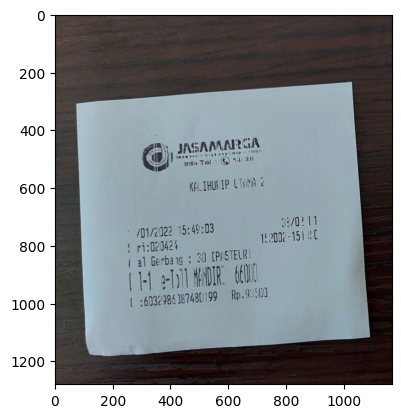

In [49]:
# https://learnopencv.com/automatic-document-scanner-using-opencv

import cv2
from matplotlib import pyplot as plt
import numpy as np


def cv2_imshow(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)


IMAGE = 'images/documents/tol.jpg'

img = cv2.imread(IMAGE)
original = img.copy()

cv2_imshow(img)


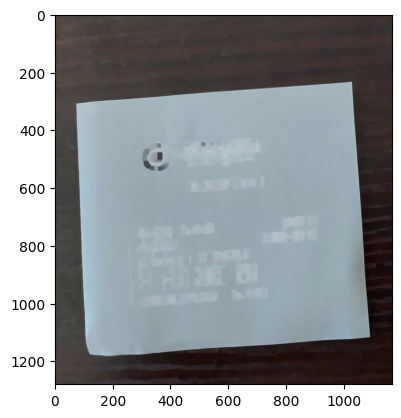

In [50]:
kernel = np.ones((5, 5), np.uint8)
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
cv2_imshow(img)

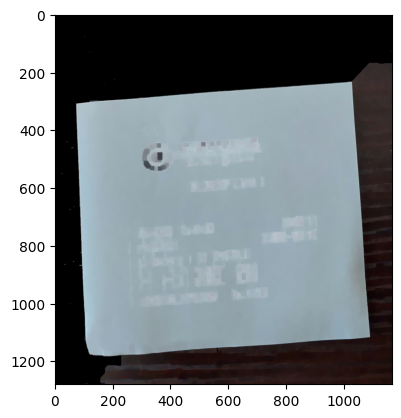

In [51]:
mask = np.zeros(img.shape[:2], np.uint8)
bgd_model = np.zeros((1, 65), np.float64)
fgd_model = np.zeros((1, 65), np.float64)
rect = (20, 20, img.shape[1] - 20, img.shape[0] - 20)
cv2.grabCut(img, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
img = img * mask2[:, :, np.newaxis]
cv2_imshow(img)

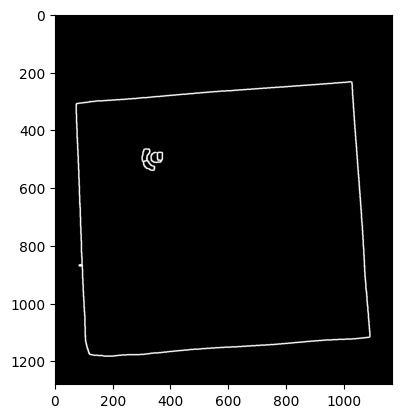

In [52]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (11, 11), 0)
canny = cv2.Canny(gray, 0, 200)
canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
cv2_imshow(canny)

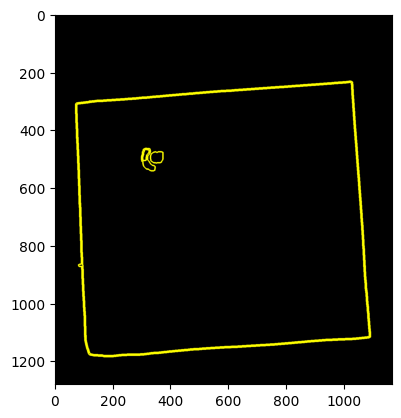

In [53]:
con = np.zeros_like(img)
contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
con = cv2.drawContours(con, page, -1, (0, 255, 255), 3)
cv2_imshow(con)

[[72, 309], [118, 1178], [1028, 234], [1091, 1117]]


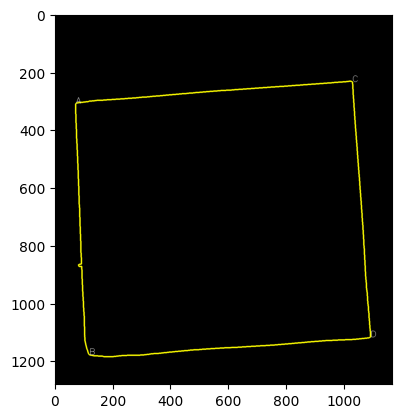

In [54]:
con = np.zeros_like(img)

for c in page:
    epsilon = 0.02 * cv2.arcLength(c, True)
    corners = cv2.approxPolyDP(c, epsilon, True)
    if len(corners) == 4:
        break

cv2.drawContours(con, c, -1, (0, 255, 255), 3)
cv2.drawContours(con, corners, -1, (0, 255, 0), 0)
corners = sorted(np.concatenate(corners).tolist())
print(corners)
for index, c in enumerate(corners):
    character = chr(65 + index)
    cv2.putText(con, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)

cv2_imshow(con)

[[72, 309], [1028, 234], [1091, 1117], [118, 1178]]
[[0, 0], [974, 0], [974, 885], [0, 885]]


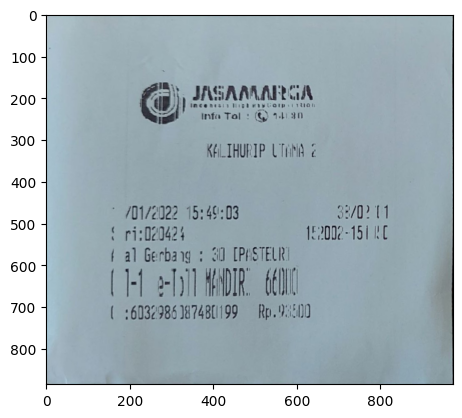

In [55]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect.astype('int').tolist()


def find_dest(pts):
    (tl, tr, br, bl) = pts

    # finding the maximum width
    width_a = np.sqrt(((br[0] - bl[0])**2) + ((br[1] - bl[1])**2))
    width_b = np.sqrt(((tr[0] - tl[0])**2) + ((tr[1] - tl[1])**2))
    max_width = max(int(width_a), int(width_b))

    # finding the maximum height
    height_a = np.sqrt(((tr[0] - br[0])**2) + ((tr[1] - br[1])**2))
    height_b = np.sqrt(((tl[0] - bl[0])**2) + ((tl[1] - bl[1])**2))
    max_height = max(int(height_a), int(height_b))

    # final destination coordinates
    destination_corners = [[0, 0], [max_width, 0], [max_width, max_height], [0, max_height]]

    return order_points(destination_corners)

corners = order_points(corners)
destination_corners = find_dest(corners)

print(corners)
print(destination_corners)

m = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
final = cv2.warpPerspective(original, m, (destination_corners[2][0], destination_corners[2][1]), flags=cv2.INTER_LINEAR)

cv2_imshow(final)